# Satellite image segmentation (miniproject)

### Attribution:

Data preprocessing notebook, base notebook structure (and unet class), and miniproject description from Harvard AM216 Spring 2022, with minor modifications.

### Miniproject description:
**Goal:** training a model that learns to identify where the **roads** and **houses** are, based on Google Map satellite images.

**Data:**
1096 training examples and 1096 test examples. Examples in both datasets are google map satellite images of urban-like regions, and each image involves roads and houses. Also, masks of roads and houses for every image. *The data is provided in .h5 format; separate notebook converts the original data to .h5 format.*

**Model:**
Unet model: takes images as input, does a per-pixel classification and outputing an segmentation map (mask). (See for example, https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)


**Miniproject guidelines:**
1. Train the two mask datasets.
  - Convert raw data to .h5 files. Optimize the best train/test split and other hyperparameters to minimize average test error. Compare the best model performance obtained on the masks for road and for houses and comment on why one mask can be learned quite better than the other.
  - Understand the structure of U-net by reading this block (https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5). *Modify the Unet architecture or use a different architecture to improve training*.
2. With the trained models from 1. Open the Google Map and take screenshots of any regions, ensuring that the new images are compatible (i.e., size, map scale, converted to black/white) with the images provided to help generalization. Then explore the following:
  - Use trained model to get (predict) the mask of new images. Does the model work well on the new images?
    - Training dataset mostly comes from urban areas - it may be difficult for the model to correctly predict rural area images. Try with map satellite images from both urban and rural areas and compare with the prediction.
  - Other potential applications: 
    - Collect the satellite image of maybe several Counties/cities of interest. Look up the population density of the corresponding area online. Then try to make a connection of the mask obtained and the population density (i.e., road density, house density, house size and road size distribution). 
    - Other quantities that may have correlation to satellite images, such as GDP per capita, may also be good targets.

In [1]:
# If running on colab, uncomment:

# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)
DATA_FILEPATH = "/content/drive/MyDrive/AM216_SatelliteMaskingProjects/Miniproject/data/"

Mounted at /content/drive


In [2]:
import numpy as np 
import os
import cv2

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras

import matplotlib.pyplot as plt
import h5py

# Create Tensorflow Datasets
from sklearn.model_selection import train_test_split

!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-etwmk6p9
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-etwmk6p9
  Created wheel for tensorflow-examples: filename=tensorflow_examples-7e028e60b236e0851a67d7a6cf982db9b4656ce2_-py3-none-any.whl size=281104 sha256=d18f6f95ea8c7540969b068df9f8df281d3e81aec787a349b691fb9b378b8cd5
  Stored in directory: /tmp/pip-ephem-wheel-cache-06qv77og/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


Here is the definition of unet.

In [3]:
def unet(input_size = (256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(inputs)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv4)
    
    drop4 = Dropout(0.5)(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)
    
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))
    
    merge6 = concatenate([drop4,up6])
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))
    
    merge7 = concatenate([conv3,up7])
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))
    
    merge8 = concatenate([conv2,up8])
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))
    
    merge9 = concatenate([conv1,up9])
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model

# Section 1: Predicting Houses and Roads

#### Our Approaches:

We first tried training the model using the base unet class provided above on the provided 256x256 images with binary crossentropy loss - this yielded poor model performance, with the model outputting mostly constant predictions across pixels. We hypothesized that this was a result of several factors:

-  Small training set size, relative to image size: we have only 1000 training examples, relative to ~65k pixels per image
-  Highly imbalanced classes: in the house dataset, only 10% of pixels correspond to houses (in the ground truth masks)
- Loss function: binary crossentropy loss is known to perform poorly with imbalanced classes

To improve model performance, we decide to take the following approaches to address each of the challenges above:

1. To deal with the small training set size, we augment our training data through random rotation and random flipping (on both the image and the mask). In particular, we increase the amount of data by 5 times for each epoch through repeated calls to augmentation.
2. Also to address small training set size, we use transfer learning: we use a pretrained encoder (mobilenetv2) as a modification to the UNet architecture, after unsuccessful attempts to improve performance by modifying the existing model structure. Doing so allows the model to start from pretrained convolutional filters, rather than having to learn both classification weights and filters simultaneously.
3. To deal with class imbalance, we modify the loss function to DICE loss + BCE loss. This is motivated by the fact that winners of image segmentation challenges typically combine BCE loss with dice (http://blog.kaggle.com/2017/12/22/carvana-image-masking-first-place-interview/), and that DICE loss takes into account overlap through intersection over union.

Separately, we also experimented with different learning rates and also using class-weights. We observed no noticeable improvement in performance through applying class-weights, after applying the above improvements.

Load file helper functions:

In [4]:
def load_h5(filepath):
    file = h5py.File(f'{DATA_FILEPATH}{filepath}', 'r')
    imgs = np.array(file.get('images')).astype('float32')
    imgs = imgs.reshape(-1, 256, 256, 1) / 255

    imgs_mask = np.array(file.get('masks')).astype('float32')
    imgs_mask /= 255  
    imgs_mask[imgs_mask <= 0.1] = 0.0
    imgs_mask[imgs_mask >= 0.9] = 1.0
    return imgs, imgs_mask

def format_data(image, mask, size = 128, channels = 3):
    if channels == 3: 
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, [size, size])
    mask = tf.image.resize(mask, [size, size])
    return image, mask

# Augmentation class for segmentation: 
# https://www.tensorflow.org/tutorials/images/segmentation
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed = 42, rotation_factor = 0.5):
        super().__init__()
        self.flip_inputs = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed = seed)
        self.rotate_inputs = tf.keras.layers.RandomRotation(rotation_factor, seed = seed)
        self.flip_labels = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed = seed)
        self.rotate_labels = tf.keras.layers.RandomRotation(rotation_factor, seed = seed)

    def call(self, inputs, labels):
        inputs = self.rotate_inputs(self.flip_inputs(inputs))
        labels = self.rotate_labels(self.flip_labels(labels))
        return inputs, labels

# Dice loss with cross entropy:
# https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
def dice_bc_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        #y_pred = tf.math.sigmoid(y_pred)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true + y_pred)
        return 1 - numerator / denominator
    o = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

# Deal with data imbalance using class weights:
# https://www.tensorflow.org/tutorials/images/segmentation
def add_sample_weights(image, label):
    class_weights = tf.constant([1.0, 10.0])
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create image of sample weights, using pixel labels to index class weights
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return image, label, sample_weights

Helper function to return train, validation, and test data:

In [5]:
# constants

VALIDATION_PROP = 0.3
EPOCHS = 10
LEARNING_RATE = 0.005
CLASS_WEIGHTS = False
AUG_INCREASE = 5 # number of times to increase the data via augmentation (via repeat())

In [6]:
def process_data(train_h5_file, test_h5_file, MODEL_TYPE = 'unet_pretrained_encoder', BATCH_SIZE = 128):
    imgs_train, imgs_mask_train = load_h5(train_h5_file)
    imgs_test, imgs_mask_test = load_h5(test_h5_file)

    STEPS_PER_EPOCH = len(imgs_train) // BATCH_SIZE

    # Training dataset
    imgs_train, imgs_val, imgs_mask_train, imgs_mask_val = train_test_split(
      imgs_train, imgs_mask_train, 
      test_size = VALIDATION_PROP, random_state = 42)

    train_data = tf.data.Dataset.from_tensor_slices((imgs_train, imgs_mask_train))

    # Validation dataset
    val_data = tf.data.Dataset.from_tensor_slices((imgs_val, imgs_mask_val))

    # Test dataset
    test_data = tf.data.Dataset.from_tensor_slices((imgs_test, imgs_mask_test))

    if MODEL_TYPE == 'unet_pretrained_encoder':
        # mobilenet requires 3 channel inputs, so need to apply grayscale_to_rgb to images and mask
        train_data = train_data.map(format_data, num_parallel_calls = tf.data.AUTOTUNE)
        val_data = val_data.map(format_data, num_parallel_calls = tf.data.AUTOTUNE)
        test_data = test_data.map(format_data, num_parallel_calls = tf.data.AUTOTUNE)

    train_data = train_data.cache().shuffle(2000).repeat(AUG_INCREASE).map(Augment()).batch(BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE)
    val_data = val_data.batch(BATCH_SIZE)
    test_data = test_data.batch(BATCH_SIZE)
    return train_data, val_data, test_data, imgs_mask_train, imgs_mask_test

## House mask prediction:

In [7]:
train_data_house, val_data_house, test_data_house, imgs_mask_train_house, imgs_mask_test_house = process_data('Dataset_house_train.h5', 'Dataset_house_test.h5')

In [8]:
print("Shape of train batch: ", next(iter(train_data_house))[0].shape)

Shape of train batch:  (128, 128, 128, 3)


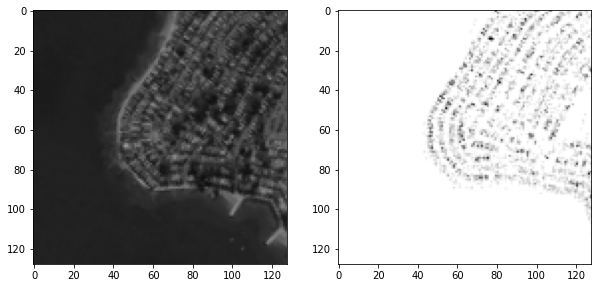

In [27]:
# Visualize an example from the augmented dataset
example_img, example_mask = next(iter(train_data_house))
fig, axes = plt.subplots(1, 2, figsize = (10,5))
axes[0].imshow(example_img[0].numpy().squeeze(), cmap = 'Greys')
axes[1].imshow(example_mask[0].numpy().squeeze(), cmap = 'Greys');

In [10]:
# Severity of class imbalance:
prop_house_pixels = (imgs_mask_train_house >= 0.5).sum() / (imgs_mask_train_house >= 0).sum()
print(f"Proportion of pixels with houses in train data: {prop_house_pixels:.2f}")

Proportion of pixels with houses in train data: 0.10


In [11]:
# Define the model type:
def build_model(train_data, MODEL_TYPE):
    INPUT_SHAPE = next(iter(train_data_house))[0].shape[1:]
    print(f"Detected input shape: {INPUT_SHAPE}")

    if MODEL_TYPE == 'unet_basic':
        # vanilla unet (the architecture provided to us in the notebook)
        model = unet(input_size = INPUT_SHAPE)
    elif MODEL_TYPE == 'unet_pretrained_encoder':
        # unet with pretrained mobilenetv2 encoder 
        # ATTRIBUTION: https://www.tensorflow.org/tutorials/images/segmentation#define_the_model
        from tensorflow_examples.models.pix2pix import pix2pix

        # define encoder:
        base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False)
        layer_names = [
          'block_1_expand_relu',   # 64x64
          'block_3_expand_relu',   # 32x32
          'block_6_expand_relu',   # 16x16
          'block_13_expand_relu',  # 8x8
          'block_16_project',      # 4x4
        ]
        base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
        down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
        down_stack.trainable = False

        # define decoder:
        up_stack = [
          pix2pix.upsample(512, 3),  # 4x4 -> 8x8
          pix2pix.upsample(256, 3),  # 8x8 -> 16x16
          pix2pix.upsample(128, 3),  # 16x16 -> 32x32
          pix2pix.upsample(64, 3),   # 32x32 -> 64x64
        ]

        def unet_model(output_channels:int):
            inputs = tf.keras.layers.Input(shape=(128, 128, 3))

            # downsample
            skips = down_stack(inputs)
            x = skips[-1]
            skips = reversed(skips[:-1])

            # upsample w/ skip connections
            for up, skip in zip(up_stack, skips):
                x = up(x)
                concat = tf.keras.layers.Concatenate()
                x = concat([x, skip])

            last = tf.keras.layers.Conv2DTranspose(
                filters=output_channels, kernel_size=3, strides=2,
                padding='same')  #64x64 -> 128x128

            x = tf.keras.activations.sigmoid(last(x)) # apply sigmoid
            return tf.keras.Model(inputs=inputs, outputs=x)

        model = unet_model(output_channels=1)
    return model 

In [12]:
model_house = build_model(train_data_house, MODEL_TYPE = 'unet_pretrained_encoder')

Detected input shape: (128, 128, 3)
9420800/9406464 [==============================] - 0s 0us/step


In [13]:
# Train the model...
def model_train(model,train_data, val_data, LOSS_FUNCTION = 'dice_bc'):
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE), 
                loss = dice_bc_loss if (LOSS_FUNCTION == 'dice_bc') else 'binary_crossentropy',
                metrics = ['accuracy'])

    print('*'*30)
    print('Fitting model...')
    print('*'*30)

    if CLASS_WEIGHTS:
        history =  model.fit(train_data.map(add_sample_weights), 
                            epochs = EPOCHS,
                            validation_data = val_data,
                            verbose=1)
    else:
        history =  model.fit(train_data, 
                            epochs = EPOCHS,
                            validation_data = val_data,
                            verbose=1)
    model_train(model_house,train_data_house, val_data_house)

******************************
Fitting model...
******************************
Epoch 1/10
30/30 [==============================] - 25s 425ms/step - loss: 1.0719 - accuracy: 0.6611 - val_loss: 2.2625 - val_accuracy: 0.6329
Epoch 2/10
30/30 [==============================] - 12s 390ms/step - loss: 0.9518 - accuracy: 0.6697 - val_loss: 1.1196 - val_accuracy: 0.7350
Epoch 3/10
30/30 [==============================] - 12s 387ms/step - loss: 0.9359 - accuracy: 0.6700 - val_loss: 0.9494 - val_accuracy: 0.7776
Epoch 4/10
30/30 [==============================] - 12s 384ms/step - loss: 0.9277 - accuracy: 0.6704 - val_loss: 0.9202 - val_accuracy: 0.7927
Epoch 5/10
30/30 [==============================] - 11s 381ms/step - loss: 0.9246 - accuracy: 0.6710 - val_loss: 0.9354 - val_accuracy: 0.7863
Epoch 6/10
30/30 [==============================] - 12s 386ms/step - loss: 0.9198 - accuracy: 0.6713 - val_loss: 0.9505 - val_accuracy: 0.7715
Epoch 7/10
30/30 [==============================] - 11s 383ms/s

Visualize the predicted masks vs true masks:

In [14]:
test_pred_house = model_house.predict(test_data_house)

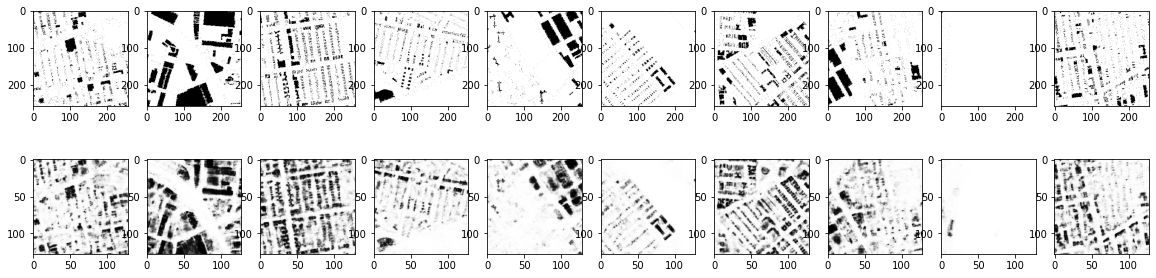

In [15]:
# Visualize predictions
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize = (20,5))
for i in range(num_images):
    axes[0][i].imshow(imgs_mask_test_house[i].squeeze(), cmap = 'Greys');
    axes[1][i].imshow(test_pred_house[i].squeeze(), cmap = 'Greys');

## Road mask prediction:

In [16]:
# process road data
train_data_road, val_data_road, test_data_road, imgs_mask_train_road, imgs_mask_test_road = process_data('Dataset_road_train.h5', 'Dataset_road_test.h5')

In [17]:
# build road model 
model_road = build_model(train_data_road, MODEL_TYPE = 'unet_pretrained_encoder')

Detected input shape: (128, 128, 3)


In [18]:
# train road model 
model_train(model_road,train_data_road, val_data_road)

******************************
Fitting model...
******************************
Epoch 1/10
30/30 [==============================] - 8s 162ms/step - loss: 1.2299 - accuracy: 0.8612 - val_loss: 2.5619 - val_accuracy: 0.8889
Epoch 2/10
30/30 [==============================] - 4s 138ms/step - loss: 0.9631 - accuracy: 0.8782 - val_loss: 1.8225 - val_accuracy: 0.8890
Epoch 3/10
30/30 [==============================] - 4s 138ms/step - loss: 0.8950 - accuracy: 0.8768 - val_loss: 1.2817 - val_accuracy: 0.8895
Epoch 4/10
30/30 [==============================] - 4s 138ms/step - loss: 0.8654 - accuracy: 0.8794 - val_loss: 1.0967 - val_accuracy: 0.8903
Epoch 5/10
30/30 [==============================] - 4s 137ms/step - loss: 0.8383 - accuracy: 0.8821 - val_loss: 0.8945 - val_accuracy: 0.8867
Epoch 6/10
30/30 [==============================] - 4s 138ms/step - loss: 0.8125 - accuracy: 0.8845 - val_loss: 0.8714 - val_accuracy: 0.8752
Epoch 7/10
30/30 [==============================] - 4s 138ms/step - l

In [19]:
# get predictions
test_pred_road = model_road.predict(test_data_road)

In [20]:
test_pred_road[1095].shape

(128, 128, 1)

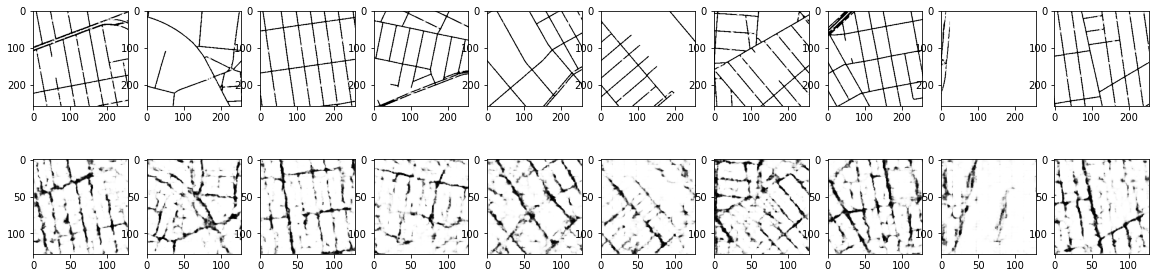

In [21]:
# Visualize predictions
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize = (20,5))
for i in range(num_images):
    axes[0][i].imshow(imgs_mask_test_road[i].squeeze(), cmap = 'Greys');
    axes[1][i].imshow(test_pred_road[i].squeeze(), cmap = 'Greys');

As we see from the performance above, the mask for roads (average evaluation accuracy of about 88%) performs quite better than the house mask (average evaluation accuracy of about 77%). However, we have to be careful with using accuracy score as metric for model performance, because there is an imbalance in pixel count per class. For example, only 10% of pixels are houses. Therefore, we should also look at the actual output to better assess the quality of model prediction. Our conjecture is that masks for houses are more fine-grained that streets. The former requires delineation of all separate blocks of houses while the latter prediction only needs straight lines. 

In our training we also noticed that when epochs = 50 the model is over-fitting, and we observe a decrease in output image quality (more blurry). We used 10 epochs because the output image quality is better. 

# Section 2: Apply Model to Other Images 

In [37]:
# import image from busy urban areas and rural areas 
dim = (128, 128) #(w,h)
names = ["manhattan-grayscale.png","SV1-modified.png","SV-bigroad-modified.png","SV-bysea-modified.png","SV-squigglyRoad-modified.png","iowa-road-modified.png","iowa-field-modified.png"]
processed_photos = []
def process_google_img(dim, names):
    for img_name in names:
        image = cv2.imread(f'{DATA_FILEPATH}{img_name}')

        # normalize
        image = image/ 255

        #print(image)

        if len(image.shape) > 2 and image.shape[2] == 4:
            #convert the image from RGBA2RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        resized = resized[np.newaxis, ...]
        print(resized.shape)
        processed_photos.append(resized)
process_google_img(dim, names)

(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)


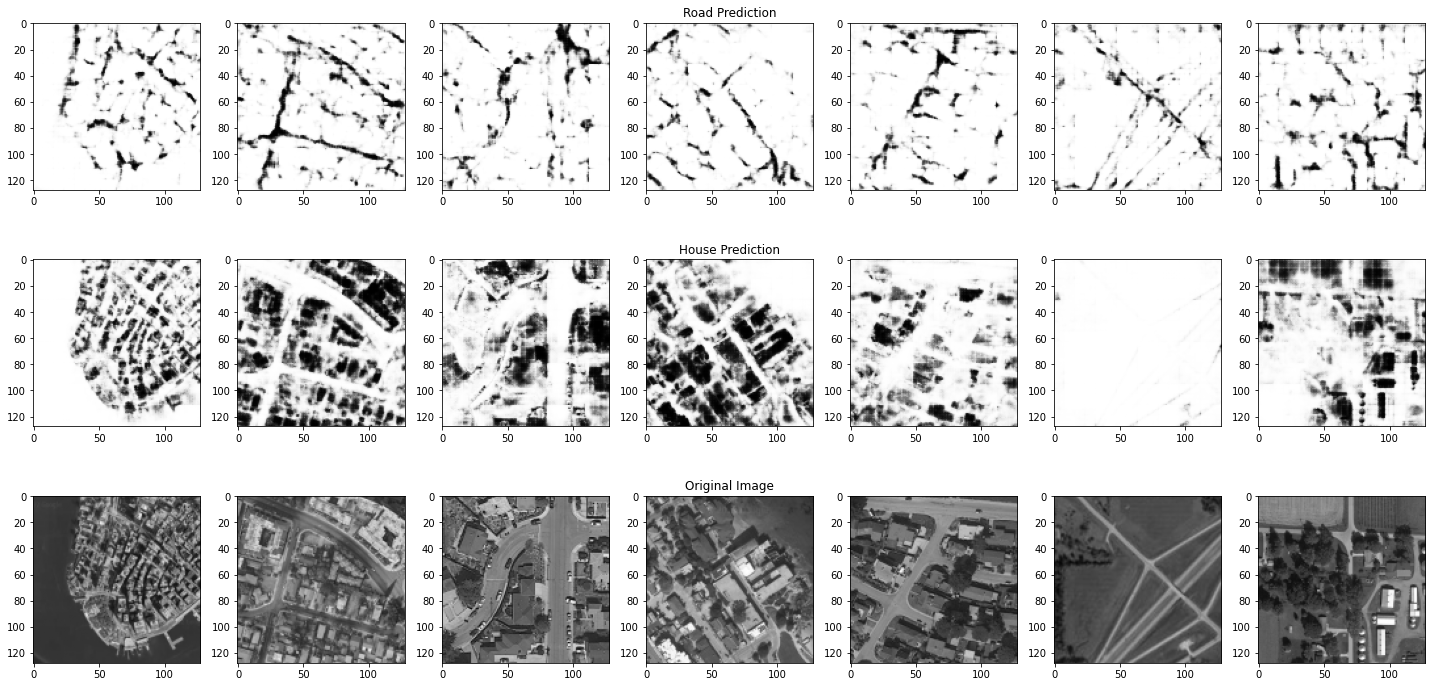

In [43]:
# Visualize predictions
num_images = 7
fig, axes = plt.subplots(3, num_images, figsize = (20,10))
for i in range(num_images):
    axes[0][i].imshow(model_road.predict(processed_photos[i]).squeeze(), cmap = 'Greys');
    axes[1][i].imshow(model_house.predict(processed_photos[i]).squeeze(), cmap = 'Greys');
    axes[2][i].imshow(processed_photos[i].squeeze(), cmap = 'Greys');
axes[0][3].set_title("Road Prediction")
axes[1][3].set_title("House Prediction")
axes[2][3].set_title("Original Image")
plt.tight_layout()

We took some screenshots from Google Satellite images, and apply our model on photos of Manhattan (look closest to our training set), Silicon Valley (more populated) and rural Iowa (less populated). Intuitively, roads prediction may not look as good because we are not telling the model to connect consecutive pixels to form line segments that indicate roads. Currently they are only pixel level predictions. 

For the Manhattan photo, the output images are consistent with what we saw earlier. For photos that are more zoomed in, the predictions are slightly worse. This is because for more zoomed out photos, we don't care as much about the boundary of houses. Some of the photos we use contain more curves and non-perpendicular intersections. Roads predictions are slightly worse because the houses and roads layout in the training dataset are more gridlike.

In addition, the model seems to pick up square blocks as houses in general. The last column is a photo of rural Iowa with corn fields, which are picked up by the model as houses. Lighting also matters in generating prediction. In the fourth photo there is a big shadow next to one of the houses, and the model predicts it to be a house as well.

In [25]:
# Another potential model to consider
# https://pallawi-ds.medium.com/semantic-segmentation-with-u-net-train-and-test-on-your-custom-data-in-keras-39e4f972ec89